# Курсовой проект

### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

### Пути к директориям и файлам

In [3]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

## 1. Посмотрим данные 
#### train

In [5]:
train.shape

(7500, 17)

In [6]:
print(train.info(memory_usage='deep'))
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


####  test

In [7]:
test.shape

(2500, 16)

In [8]:
print(test.info(memory_usage='deep'))
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


**Анализ целевой переменной**

In [9]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [10]:
train['Credit Default'].value_counts()[0] / train['Credit Default'].value_counts()[1]

2.549455750118315

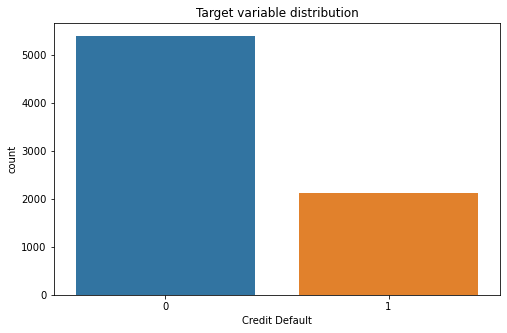

In [11]:
plt.figure(figsize=(8, 5))

sns.countplot(x = 'Credit Default', data = train)

plt.title('Target variable distribution')
plt.show()

**корреляция с базовыми признаками**

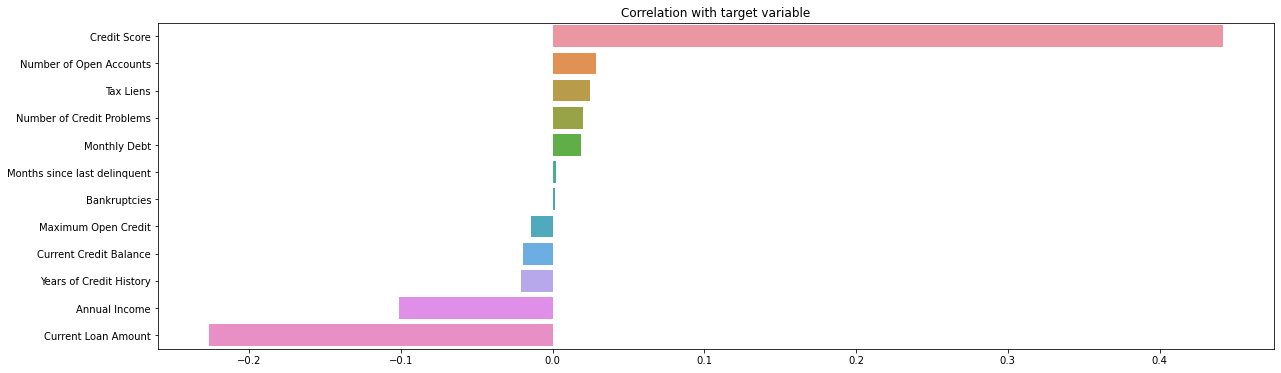

In [12]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train.columns.drop(TARGET_NAME).tolist()


corr_with_target = train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(20, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()


***Анализ признаков***

In [13]:
# Подсчитаем пропуски
(len(train) - train.count()).sort_values(ascending = False)

Months since last delinquent    4081
Annual Income                   1557
Credit Score                    1557
Years in current job             371
Bankruptcies                      14
Maximum Open Credit                0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Credit Default                     0
Number of Credit Problems          0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Home Ownership                     0
dtype: int64

In [14]:
# Подсчитаем пропуски
(len(test) - test.count()).sort_values(ascending = False)

Months since last delinquent    1358
Credit Score                     513
Annual Income                    513
Years in current job              86
Bankruptcies                       3
Monthly Debt                       0
Current Credit Balance             0
Current Loan Amount                0
Term                               0
Purpose                            0
Number of Credit Problems          0
Maximum Open Credit                0
Years of Credit History            0
Number of Open Accounts            0
Tax Liens                          0
Home Ownership                     0
dtype: int64

In [15]:
# Подсчитаем нулевые значения(
(train[train == 0].count()).sort_values(ascending = False).head(50)

Tax Liens                       7366
Bankruptcies                    6660
Number of Credit Problems       6469
Credit Default                  5387
Maximum Open Credit               65
Current Credit Balance            53
Months since last delinquent      18
Monthly Debt                       6
Purpose                            0
Credit Score                       0
Term                               0
Current Loan Amount                0
Years of Credit History            0
Number of Open Accounts            0
Years in current job               0
Annual Income                      0
Home Ownership                     0
dtype: int64

In [16]:
# Подсчитаем нулевые значения(
(test[test == 0].count()).sort_values(ascending = False).head(50)

Tax Liens                       2445
Bankruptcies                    2252
Number of Credit Problems       2177
Maximum Open Credit               14
Current Credit Balance            11
Months since last delinquent       8
Credit Score                       0
Monthly Debt                       0
Current Loan Amount                0
Term                               0
Purpose                            0
Years of Credit History            0
Number of Open Accounts            0
Years in current job               0
Annual Income                      0
Home Ownership                     0
dtype: int64

**Home Ownership**

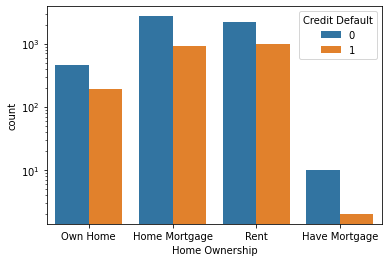

In [17]:
sns.countplot(train['Home Ownership'], hue=train['Credit Default'], log=True);

In [18]:
train['Home Ownership'].value_counts(normalize=True)

Home Mortgage    0.484933
Rent             0.427200
Own Home         0.086267
Have Mortgage    0.001600
Name: Home Ownership, dtype: float64

In [19]:
train.groupby(['Home Ownership'])['Credit Default'].mean()

Home Ownership
Have Mortgage    0.166667
Home Mortgage    0.251856
Own Home         0.296754
Rent             0.313046
Name: Credit Default, dtype: float64

**Annual Income**

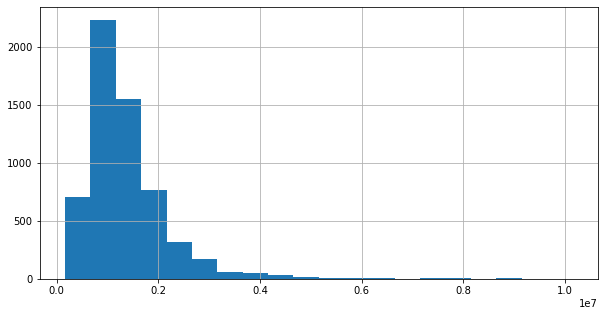

In [20]:
train['Annual Income'].hist(bins=20, figsize=(10, 5))
plt.show()

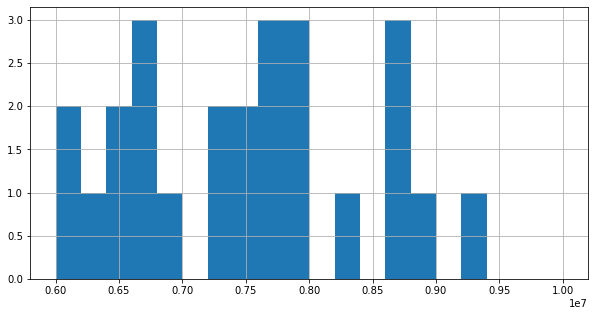

In [21]:
train['Annual Income'].hist(bins=20, range = (6000000, 10000000), figsize=(10, 5))
plt.show()

есть "дискретные" значения, но это на больших суммах. не вижу смысла что-то делать

посмотрим на test

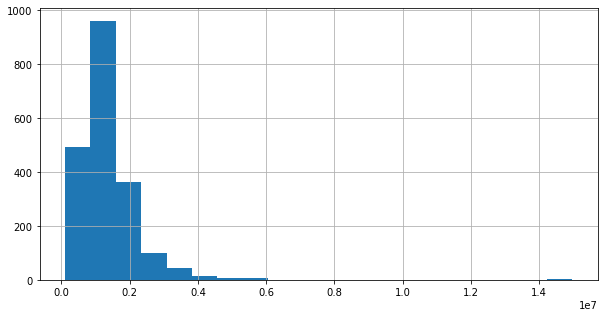

In [22]:
test['Annual Income'].hist(bins=20, figsize=(10, 5))
plt.show()

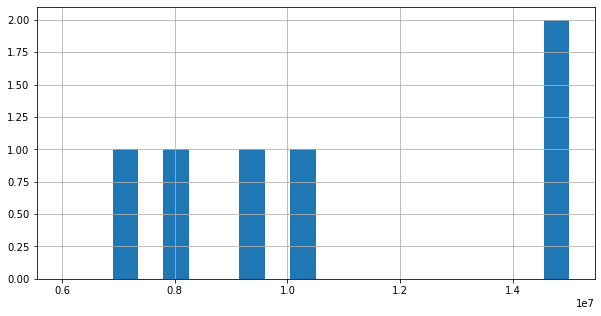

In [23]:
test['Annual Income'].hist(bins=20, range = (6000000, 15000000), figsize=(10, 5))
plt.show()

In [24]:
# очевиден выброс, заменяю
test.loc[test['Annual Income'] > 1.4*10**7, 'Annual Income'] = test['Annual Income'].median()

In [25]:
test[test['Annual Income'] > 1.4*10**7].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


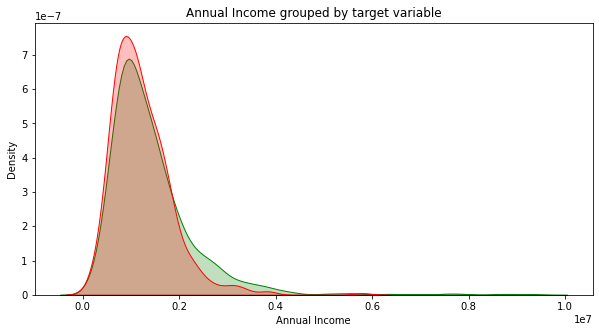

In [26]:
# посмотрим в разрезе целевой переменной
annual_with_target_s = train[['Annual Income', TARGET_NAME]].sample(2000)
annual_s = annual_with_target_s['Annual Income']
annual_target_0 = annual_s[annual_with_target_s[TARGET_NAME] == 0]
annual_target_1 = annual_s[annual_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_target_0, shade=True, label='No default', color='g')
sns.kdeplot(annual_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

In [27]:
import scipy
scipy.stats.shapiro(annual_s)

ShapiroResult(statistic=nan, pvalue=1.0)

In [28]:
scipy.stats.mannwhitneyu(annual_target_0, annual_target_1)

MannwhitneyuResult(statistic=402334.5, pvalue=0.18989689017290817)

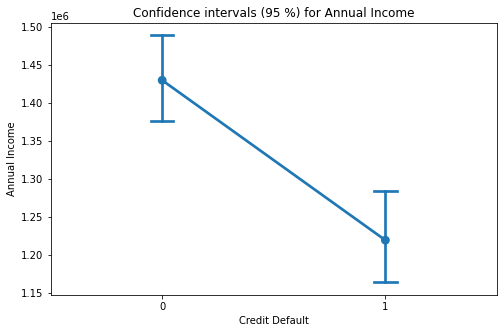

In [29]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=annual_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

Средние значения по целевой переменной значимо отличаются, следовательно, этот признак может быть полезен для определения целевой переменной

**Years in current job**

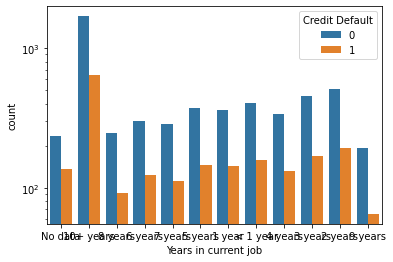

In [30]:
# посмотрим в разрезе целевой переменной
sns.countplot(train['Years in current job'].fillna('No data'), hue=train['Credit Default'], log=True);

In [31]:
# посмотрим пропуски
train['Years in current job'].fillna('No data').value_counts(normalize=True)

10+ years    0.310933
2 years      0.094000
3 years      0.082667
< 1 year     0.075067
5 years      0.068800
1 year       0.067200
4 years      0.062533
6 years      0.056800
7 years      0.052800
No data      0.049467
8 years      0.045200
9 years      0.034533
Name: Years in current job, dtype: float64

In [32]:
test['Years in current job'].fillna('No data').value_counts(normalize=True)

10+ years    0.3240
3 years      0.0912
2 years      0.0848
< 1 year     0.0828
5 years      0.0676
1 year       0.0612
4 years      0.0608
7 years      0.0560
6 years      0.0548
8 years      0.0428
9 years      0.0396
No data      0.0344
Name: Years in current job, dtype: float64

In [33]:
# заменим пропуски на моду
train['Years in current job'].mode()[0]

'10+ years'

In [34]:
test['Years in current job'].mode()[0]

'10+ years'

In [35]:
train['Years in current job'].fillna(train['Years in current job'].mode()[0], inplace=True)
test['Years in current job'].fillna(train['Years in current job'].mode()[0], inplace=True)

<AxesSubplot:xlabel='Years in current job', ylabel='Count'>

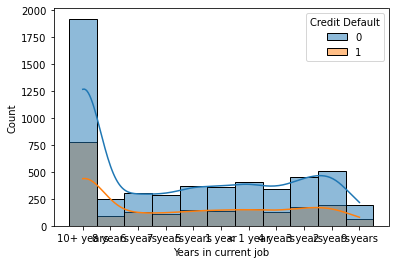

In [36]:
sns.histplot(x='Years in current job', hue=TARGET_NAME,kde=True, alpha=0.5, data=train)

**Tax Liens**

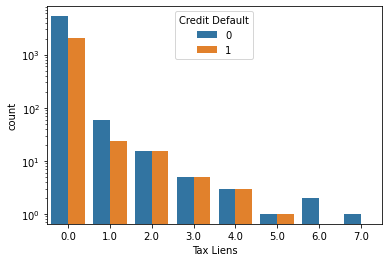

In [37]:
sns.countplot(train['Tax Liens'], hue=train['Credit Default'], log=True);

In [38]:
train['Tax Liens'].value_counts(normalize=True)

0.0    0.982133
1.0    0.011067
2.0    0.004000
3.0    0.001333
4.0    0.000800
5.0    0.000267
6.0    0.000267
7.0    0.000133
Name: Tax Liens, dtype: float64

In [39]:
train.groupby(['Tax Liens'])['Credit Default'].mean()

Tax Liens
0.0    0.280342
1.0    0.289157
2.0    0.500000
3.0    0.500000
4.0    0.500000
5.0    0.500000
6.0    0.000000
7.0    0.000000
Name: Credit Default, dtype: float64

**Number of Open Accounts**

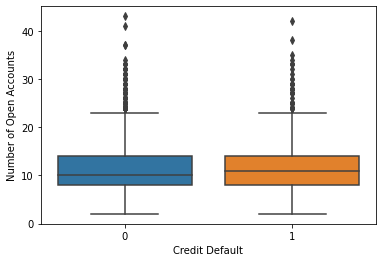

In [40]:
sns.boxplot(x=train['Credit Default'], y=(train['Number of Open Accounts']));

**Years of Credit History**

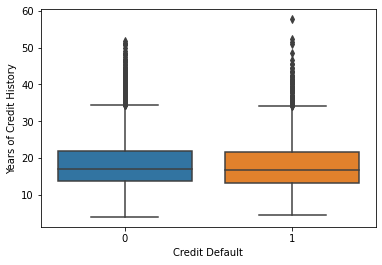

In [41]:
sns.boxplot(x=train['Credit Default'], y=(train['Years of Credit History']));

In [42]:
print(train[train['Years of Credit History'] > 55].shape[0])
train[train['Years of Credit History'] > 55].head()

1


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
476,Home Mortgage,1076768.0,10+ years,0.0,14.0,57.7,432124.0,0.0,24.0,0.0,debt consolidation,Long Term,558360.0,186219.0,13818.0,667.0,1


**Maximum Open Credit**

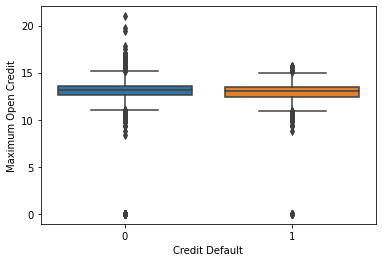

In [43]:
sns.boxplot(x=train['Credit Default'], y=np.log1p(train['Maximum Open Credit']));

In [44]:
print(train[np.log1p(train['Maximum Open Credit']) > 16].shape[0])
train[np.log1p(train['Maximum Open Credit']) > 16]

26


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
85,Home Mortgage,1301614.0,9 years,0.0,17.0,18.0,9.339924e+06,0.0,NaN,0.0,debt consolidation,Short Term,592240.0,959899.0,16813.0,748.0,0
354,Home Mortgage,2126537.0,10+ years,0.0,23.0,23.0,1.476048e+07,0.0,NaN,0.0,debt consolidation,Long Term,778624.0,1019806.0,40227.0,697.0,0
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0
1476,Own Home,NaN,8 years,0.0,14.0,28.9,1.042866e+07,0.0,NaN,0.0,debt consolidation,Short Term,656766.0,1089802.0,16531.0,NaN,0
1879,Home Mortgage,1433835.0,6 years,0.0,8.0,17.8,1.270144e+07,0.0,35.0,0.0,debt consolidation,Short Term,197384.0,1985462.0,14099.0,749.0,0
2023,Rent,1342825.0,10+ years,0.0,12.0,16.3,5.756256e+07,0.0,NaN,0.0,other,Short Term,166826.0,944547.0,9176.0,749.0,0
2036,Home Mortgage,1172984.0,4 years,0.0,6.0,24.2,9.094184e+06,0.0,NaN,0.0,business loan,Long Term,335324.0,1413733.0,8709.0,748.0,0
2431,Own Home,1283279.0,10+ years,0.0,17.0,31.4,8.947840e+06,0.0,26.0,0.0,debt consolidation,Short Term,350350.0,2024659.0,25880.0,747.0,0
2468,Home Mortgage,5589420.0,4 years,0.0,11.0,12.3,1.634591e+07,0.0,24.0,0.0,home improvements,Long Term,99999999.0,2315169.0,74991.0,735.0,0


In [45]:
print(train[np.log1p(train['Maximum Open Credit']) == 0].shape[0])
train[np.log1p(train['Maximum Open Credit']) == 0].head()

65


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0


**Number of Credit Problems**

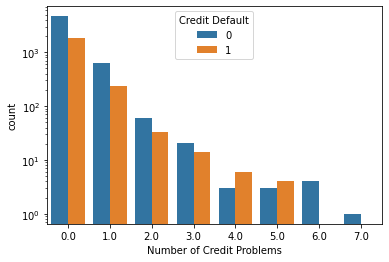

In [46]:
sns.countplot(train['Number of Credit Problems'], hue=train['Credit Default'], log=True);

In [47]:
train['Number of Credit Problems'].value_counts(normalize=True)

0.0    0.862533
1.0    0.117600
2.0    0.012400
3.0    0.004667
4.0    0.001200
5.0    0.000933
6.0    0.000533
7.0    0.000133
Name: Number of Credit Problems, dtype: float64

In [48]:
train.groupby(['Number of Credit Problems'])['Credit Default'].mean()

Number of Credit Problems
0.0    0.280569
1.0    0.273243
2.0    0.354839
3.0    0.400000
4.0    0.666667
5.0    0.571429
6.0    0.000000
7.0    0.000000
Name: Credit Default, dtype: float64

**Months since last delinquent**

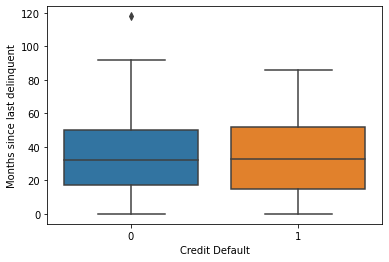

In [49]:
sns.boxplot(x=train['Credit Default'], y=train['Months since last delinquent']);

In [50]:
print(train[train['Months since last delinquent'] > 100].shape[0])
train[train['Months since last delinquent'] > 100].head()

1


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4191,Home Mortgage,3009201.0,6 years,0.0,10.0,20.8,773322.0,0.0,118.0,0.0,debt consolidation,Short Term,449592.0,299877.0,15297.0,738.0,0


**Bankruptcies**

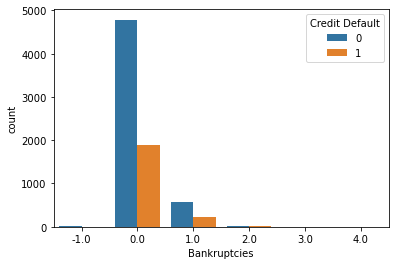

In [51]:
sns.countplot(train['Bankruptcies'].fillna(-1), hue=train['Credit Default']);

In [52]:
train['Bankruptcies'].fillna(-1).value_counts(normalize=True)

 0.0    0.888000
 1.0    0.104800
 2.0    0.004133
-1.0    0.001867
 3.0    0.000933
 4.0    0.000267
Name: Bankruptcies, dtype: float64

In [53]:
train.groupby(train['Bankruptcies'].fillna(-1))['Credit Default'].mean()

Bankruptcies
-1.0    0.285714
 0.0    0.281982
 1.0    0.276081
 2.0    0.354839
 3.0    0.285714
 4.0    0.500000
Name: Credit Default, dtype: float64

**Purpose**

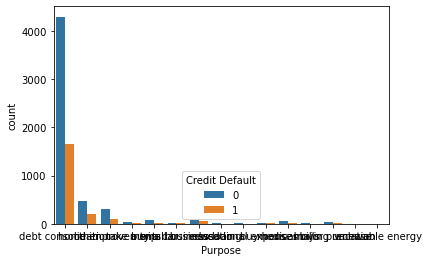

In [54]:
sns.countplot(train['Purpose'], hue=train['Credit Default']);

In [55]:
train['Purpose'].value_counts(normalize=True)

debt consolidation      0.792533
other                   0.088667
home improvements       0.054933
business loan           0.017200
buy a car               0.012800
medical bills           0.009467
major purchase          0.005333
take a trip             0.004933
buy house               0.004533
small business          0.003467
wedding                 0.002000
moving                  0.001467
educational expenses    0.001333
vacation                0.001067
renewable energy        0.000267
Name: Purpose, dtype: float64

In [56]:
train.groupby(['Purpose'])['Credit Default'].mean()

Purpose
business loan           0.426357
buy a car               0.250000
buy house               0.264706
debt consolidation      0.278264
educational expenses    0.100000
home improvements       0.262136
major purchase          0.225000
medical bills           0.309859
moving                  0.181818
other                   0.296241
renewable energy        1.000000
small business          0.538462
take a trip             0.270270
vacation                0.250000
wedding                 0.266667
Name: Credit Default, dtype: float64

**Term**

In [57]:
train['Term'].value_counts(normalize=True)

Short Term    0.7408
Long Term     0.2592
Name: Term, dtype: float64

In [58]:
train.groupby(['Term'])['Credit Default'].mean()

Term
Long Term     0.419753
Short Term    0.233441
Name: Credit Default, dtype: float64

**Current Loan Amount**

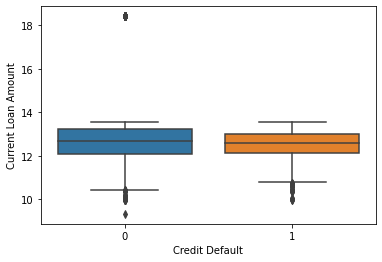

In [59]:
sns.boxplot(x=train['Credit Default'], y=np.log1p(train['Current Loan Amount']));

In [60]:
print(train[np.log1p(train['Current Loan Amount']) > 14].shape[0])
train[np.log1p(train['Current Loan Amount']) > 14].head()

870


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
22,Rent,463790.0,10+ years,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,195966.0,6041.0,734.0,0


**Current Credit Balance**

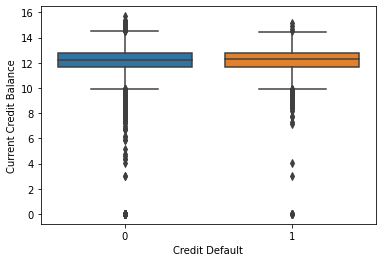

In [61]:
sns.boxplot(x=train['Credit Default'], y=np.log1p(train['Current Credit Balance']));

In [62]:
print(train[np.log1p(train['Current Credit Balance']) == 0].shape[0])
train[np.log1p(train['Current Credit Balance']) == 0].head()

53


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0
319,Own Home,NaN,< 1 year,0.0,2.0,10.5,0.0,0.0,NaN,0.0,business loan,Short Term,76670.0,0.0,6432.0,NaN,0


**Monthly Debt**

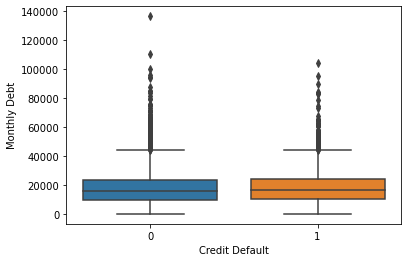

In [63]:
sns.boxplot(x=train['Credit Default'], y=(train['Monthly Debt']));

In [64]:
print(train[train['Monthly Debt'] > 120000].shape[0])
train[train['Monthly Debt'] > 120000].head()

1


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4745,Own Home,6029954.0,4 years,0.0,30.0,17.5,11603856.0,0.0,NaN,0.0,debt consolidation,Short Term,753588.0,4720132.0,136679.0,745.0,0


**Credit Score**

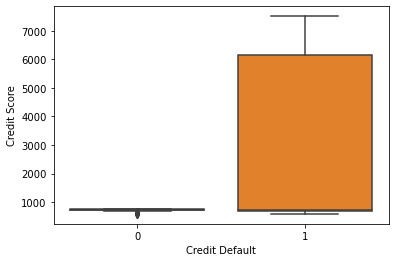

In [65]:
sns.boxplot(x=train['Credit Default'], y=(train['Credit Score']));

In [66]:
print(train[train['Credit Score'] > 1000].shape[0])
train[train['Credit Score'] > 1000].head()

400


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.0,2 years,0.0,12.0,17.5,700062.0,0.0,21.0,0.0,other,Long Term,525998.0,174135.0,9320.0,6470.0,1
87,Home Mortgage,1533566.0,7 years,0.0,11.0,14.8,715462.0,0.0,19.0,0.0,debt consolidation,Short Term,210826.0,285475.0,18147.0,7440.0,1
94,Rent,1049294.0,3 years,0.0,5.0,6.1,249810.0,0.0,NaN,0.0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0,1
96,Rent,757568.0,5 years,0.0,13.0,11.4,383548.0,0.0,NaN,0.0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1
116,Home Mortgage,1039984.0,10+ years,0.0,10.0,23.8,147950.0,0.0,63.0,0.0,debt consolidation,Short Term,224246.0,95456.0,13780.0,7390.0,1


Обработаем выбросы в train

In [67]:
train_2 = train[~train['Tax Liens'].isin([6, 7])].copy()
train_2 = train_2[train_2['Maximum Open Credit'] > 0]
train_2 = train_2[np.log1p(train_2['Maximum Open Credit']) <= 16]
train_2 = train_2[~train_2['Number of Credit Problems'].isin([6, 7])]
train_2 = train_2[train_2['Months since last delinquent'].fillna(0) <= 100]
train_2 = train_2[np.log1p(train_2['Current Loan Amount']) <= 14]
train_2 = train_2[np.log1p(train_2['Current Credit Balance']) > 0]
train_2 = train_2[~train_2['Purpose'].isin(['renewable energy'])]
train_2 = train_2[train_2['Monthly Debt'] <= 120000]

In [68]:
print(train_2.shape)

(6548, 17)


In [69]:
train_2.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1


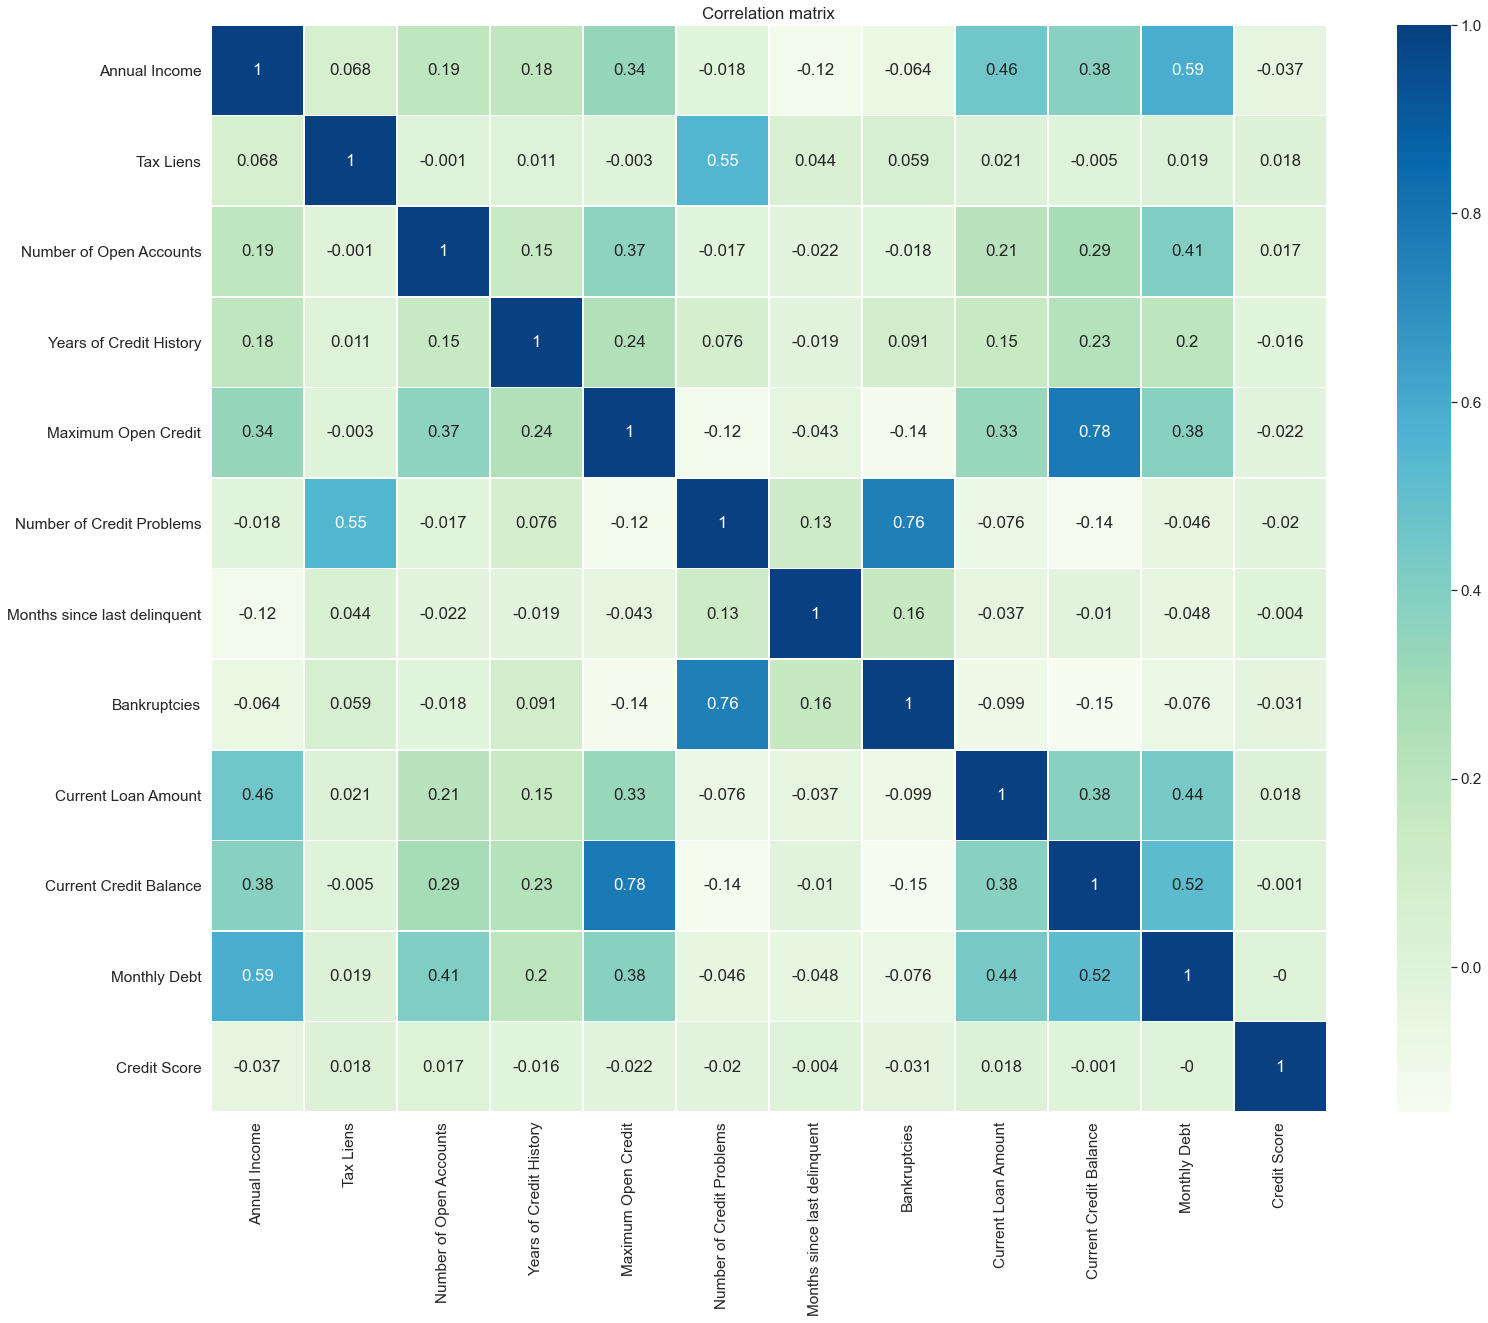

In [70]:
# матрица корреляции
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(train_2[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Предобработка данных**

In [71]:
cat_features = list(train_2.select_dtypes(include=[object]).columns.values)
num_features = list(feature for feature in train.columns if feature not in cat_features )

In [72]:
def preproc(input_data, categorical_features=[]):
    
    output_data = input_data.copy()
    output_data['Annual Income'].fillna(-1, inplace=True)
    output_data['Years in current job'].fillna('No data', inplace=True)
    output_data['Credit Score'].fillna(-1, inplace=True)
    output_data['Months since last delinquent'].fillna(-1, inplace=True)
    output_data['Bankruptcies'].fillna(-1, inplace=True)
    
    if len(categorical_features) > 0:
        
        X = pd.get_dummies(output_data, columns=cat_features, drop_first=False).copy()
        
        if 'Credit Default' in X.columns:
            X.drop(['Credit Default'], axis=1, inplace=True)
            y = output_data['Credit Default'].values.copy()

            return X, y
        
        else:
            return X
    
    else:
        
        X = output_data.copy()
        
        if 'Credit Default' in X.columns:
            X.drop(['Credit Default'], axis=1, inplace=True)
            y = output_data['Credit Default'].values.copy()

            return X, y
        
        else:
            return X

In [73]:
X, y = preproc(train_2, cat_features)

In [74]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6548 entries, 1 to 7499
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   6548 non-null   float64
 1   Tax Liens                       6548 non-null   float64
 2   Number of Open Accounts         6548 non-null   float64
 3   Years of Credit History         6548 non-null   float64
 4   Maximum Open Credit             6548 non-null   float64
 5   Number of Credit Problems       6548 non-null   float64
 6   Months since last delinquent    6548 non-null   float64
 7   Bankruptcies                    6548 non-null   float64
 8   Current Loan Amount             6548 non-null   float64
 9   Current Credit Balance          6548 non-null   float64
 10  Monthly Debt                    6548 non-null   float64
 11  Credit Score                    6548 non-null   float64
 12  Home Ownership_Have Mortgage    65

In [75]:
X.shape

(6548, 43)

In [76]:
X.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,-1.0,0.0,264968.0,394972.0,...,0,0,0,0,0,0,0,0,1,0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,-1.0,1.0,121396.0,95855.0,...,0,0,0,0,0,0,0,0,0,1
4,776264.0,0.0,13.0,13.6,385836.0,1.0,-1.0,0.0,125840.0,93309.0,...,0,0,0,0,0,0,0,0,0,1
5,-1.0,0.0,12.0,14.6,366784.0,0.0,-1.0,0.0,337304.0,165680.0,...,0,0,0,1,0,0,0,0,1,0
7,1040060.0,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,250888.0,89015.0,...,0,0,0,1,0,0,0,0,0,1


**Отбор признаков**

In [77]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, log_loss, f1_score, classification_report
from lightgbm import LGBMClassifier


In [78]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [79]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [80]:
clf = LGBMClassifier(random_state=42)

rfecv = RFECV(clf, cv=skf, scoring='neg_log_loss', n_jobs=2)

rfecv.fit(X_train.values, y_train)

features = rfecv.support_

In [81]:
print(f'Из {X.shape[1]} отобрано {np.sum(features)} признаков')
print(X_train.loc[:, features].columns)

Из 43 отобрано 11 признаков
Index(['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score',
       'Term_Long Term'],
      dtype='object')


### Построение и оценка базовых моделей

In [82]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

**Логистическая регрессия**

In [83]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_valid_pred = model_lr.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.97      0.83      3112
           1       0.78      0.24      0.37      1471

    accuracy                           0.73      4583
   macro avg       0.75      0.60      0.60      4583
weighted avg       0.74      0.73      0.68      4583

TEST

              precision    recall  f1-score   support

           0       0.73      0.97      0.83      1335
           1       0.79      0.23      0.35       630

    accuracy                           0.73      1965
   macro avg       0.76      0.60      0.59      1965
weighted avg       0.75      0.73      0.68      1965

CONFUSION MATRIX

col_0     0    1
row_0           
0      1298   37
1       488  142


**k ближайших соседей**

In [84]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_valid_pred = model_knn.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.90      0.83      3112
           1       0.66      0.41      0.51      1471

    accuracy                           0.74      4583
   macro avg       0.71      0.66      0.67      4583
weighted avg       0.73      0.74      0.72      4583

TEST

              precision    recall  f1-score   support

           0       0.69      0.81      0.75      1335
           1       0.37      0.24      0.29       630

    accuracy                           0.63      1965
   macro avg       0.53      0.52      0.52      1965
weighted avg       0.59      0.63      0.60      1965

CONFUSION MATRIX

col_0     0    1
row_0           
0      1084  251
1       481  149


**Бустинговые алгоритмы**

*LightGBM*

In [86]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      3112
           1       0.98      0.71      0.82      1471

    accuracy                           0.90      4583
   macro avg       0.93      0.85      0.88      4583
weighted avg       0.91      0.90      0.90      4583

TEST

              precision    recall  f1-score   support

           0       0.75      0.92      0.83      1335
           1       0.69      0.36      0.47       630

    accuracy                           0.74      1965
   macro avg       0.72      0.64      0.65      1965
weighted avg       0.73      0.74      0.72      1965

CONFUSION MATRIX

col_0     0    1
row_0           
0      1234  101
1       403  227


*CatBoost*

А вот здесь все "виснет". Причину обыскалась...

In [87]:
#model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
#model_catb.fit(X_train, y_train)

#y_train_pred = model_catb.predict(X_train)
#y_valid_pred = model_catb.predict(X_valid)

#get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

### Выбор лучшей модели и подбор гиперпараметров

In [88]:
model_LGBM = LGBMClassifier(n_estimators=100, max_depth=3, random_state=42)

**Подбор гиперпараметров**

In [90]:
params = {'n_estimators': np.arange(100, 221, 10),
    'max_depth': np.arange(2, 7, 1)}

cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [91]:
%%time

rs = RandomizedSearchCV(model_LGBM, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 5.89 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=LGBMClassifier(max_depth=3, random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([2, 3, 4, 5, 6]),
                                        'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220])},
                   scoring='f1')

In [92]:
rs.best_params_

{'n_estimators': 190, 'max_depth': 6}

In [93]:
rs.best_score_

0.47135093047677046

Полагаю, что этого недостаточно((((

**Предсказание на тестовых данных**


In [94]:
from sklearn.base import clone

In [95]:
model = clone(rs.best_estimator_)

model.fit(X.loc[:, features], y)

LGBMClassifier(max_depth=6, n_estimators=190, random_state=42)

In [96]:
X_test = preproc(test, cat_features)

In [104]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   2500 non-null   float64
 1   Tax Liens                       2500 non-null   float64
 2   Number of Open Accounts         2500 non-null   float64
 3   Years of Credit History         2500 non-null   float64
 4   Maximum Open Credit             2500 non-null   float64
 5   Number of Credit Problems       2500 non-null   float64
 6   Months since last delinquent    2500 non-null   float64
 7   Bankruptcies                    2500 non-null   float64
 8   Current Loan Amount             2500 non-null   float64
 9   Current Credit Balance          2500 non-null   float64
 10  Monthly Debt                    2500 non-null   float64
 11  Credit Score                    2500 non-null   float64
 12  Home Ownership_Have Mortgage    25

In [103]:
X_test.isna().sum()

Annual Income                     0
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent      0
Bankruptcies                      0
Current Loan Amount               0
Current Credit Balance            0
Monthly Debt                      0
Credit Score                      0
Home Ownership_Have Mortgage      0
Home Ownership_Home Mortgage      0
Home Ownership_Own Home           0
Home Ownership_Rent               0
Years in current job_1 year       0
Years in current job_10+ years    0
Years in current job_2 years      0
Years in current job_3 years      0
Years in current job_4 years      0
Years in current job_5 years      0
Years in current job_6 years      0
Years in current job_7 years      0
Years in current job_8 years      0
Years in current job_9 years      0
Years in current job_< 1 year     0
Purpose_business loan       

In [107]:
y_test_proba = model.predict_proba(X_test.loc[:, features].values)
y_test_hat = np.array(y_test_proba[:, 1] >= 0.5).astype(int)


In [108]:
predictions = pd.DataFrame()
predictions['Credit Default'] = y_test_hat

In [109]:
predictions.head()

,Credit Default
0,0
1,1
2,1
3,0
4,0


In [110]:
predictions.to_csv('NGladkova_predictions.csv', index=True, encoding='utf-8')